# Загружаем и распаковываем датасет

In [ ]:
!gdown 19X6rTKOXcNXh3FBP7pCZH8AM4PpMmakw

Downloading...
From: https://drive.google.com/uc?id=19X6rTKOXcNXh3FBP7pCZH8AM4PpMmakw
To: /content/shapes.zip
100% 22.6M/22.6M [00:00<00:00, 52.0MB/s]


In [ ]:
!unzip -q shapes.zip

replace display_model.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Подготовка

In [ ]:
#@title Инициализируем рандом, что бы он был повторяемым
import random
import numpy as np
import torch
SEED = 42 #@param {type:"integer"}

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

In [ ]:
#@title Датасет (трнсформы, метки и прочая)
from torchvision import datasets, transforms

transform = transforms.Compose(
    [
      transforms.Grayscale(num_output_channels=1),
      #transforms.Resize(80),
      #transforms.RandomCrop(64),
      transforms.RandomResizedCrop(64,scale=(0.50,1.5)),
      #transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

data = datasets.ImageFolder('shapes', transform = transform)
labels = ['circle','square','star','triangle','test']

In [ ]:
from torch.utils.data import random_split

test_data, train_data = random_split(data , [0.2, 0.8], generator=torch.Generator().manual_seed(42))

In [ ]:
from torch.utils.data import DataLoader
batch_size = 256
data_tr = DataLoader(train_data, batch_size=batch_size, shuffle=True)
data_val = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
train_data[0][0].shape

torch.Size([1, 64, 64])

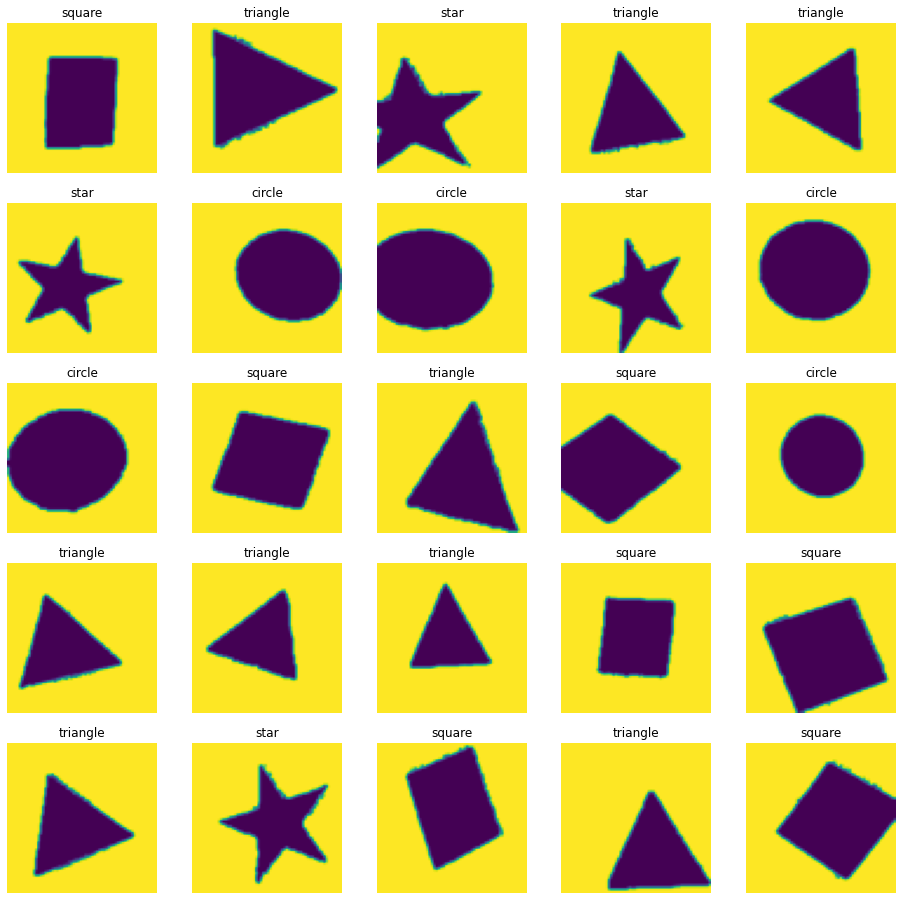

In [ ]:
#@title Посмотрим что там
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(16, 16))
for i in range(25):
    j = random.randrange(0,len(train_data))
    plt.subplot(5, 5, i+1)
    plt.title(labels[train_data[j][1]])
    plt.axis("off")
    plt.imshow(train_data[j][0].squeeze())

plt.show();

In [ ]:
#@title Наша модель (VAE - вариационный, сверточный автоэнкодер)
from torch import nn

class VAE(nn.Module):
    def __init__(self, ch=1, zDim=8):
        super(VAE, self).__init__()
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(ch, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1) # 64 -> 32
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=1) # 32 -> 16
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.5),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=1) # 16 -> 8

        # bottleneck
        self.mu_FC = nn.Linear(128*8*8, zDim)
        self.sigma_FC = nn.Linear(128*8*8, zDim)

        self.dec_FC = nn.Linear(zDim, 128*8*8)

        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), # 8 -> 16
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), # 16 -> 32
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(32, ch, 2, stride=2), # 32 -> 64
            #nn.BatchNorm2d(32, momentum=0.5),
            nn.Sigmoid(),
        )

    def encode(self, x):
        # encoder
        x = self.pool1(self.enc_conv1(x))
        x = self.pool2(self.enc_conv2(x))
        x = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = x.reshape(-1, 128*8*8)
        mu = self.mu_FC(x)
        logsigma = self.sigma_FC(x)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        x = self.dec_FC(z)
        x = x.reshape(-1, 128,8,8)

        # decoder
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        x = self.dec_conv3(x)
        return x

    def forward(self, x):
        mu, logsigma = self.encode(x)
        samle = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(samle)
        return mu, logsigma, reconstruction

In [ ]:
#@title Loss функция: правдоподобие + дивергения
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum') #<binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return  KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

# Инициализируем модель и учим

In [ ]:
criterion = loss_vae

autoencoder = VAE(zDim=16)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#@title Процедура тренировки с выводом промежуточных результатов
def train(model, opt, loss_fn, epochs, data_tr, data_val, usecls=False):
    for epoch in range(epochs):
        val = next(iter(data_val))
        if type(val) is tuple:
          val,vcls = val
        elif type(val) is list:
          vcls = val[1]
          val = val[0]
        #tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            if type(batch) is tuple:
              batch,cls = batch
            elif type(batch) is list:
              cls = batch[1]
              batch = batch[0]
            # data to device
            batch = batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            #print(batch.shape)
            if usecls:
              mu, sigma, pred = model(batch,cls.to(device))
            else:
              mu, sigma, pred = model(batch)
            #print(Y_pred.shape,Y_batch.shape)
            loss = loss_fn(batch, mu, sigma, pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        #toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          if usecls:
            _, _, Y_hat = model(val.to(device),vcls.to(device)) # detach and put into cpu
          else:
            _, _, Y_hat = model(val.to(device)) # detach and put into cpu
          Y_hat = Y_hat.cpu()
        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(val[k][0].numpy())#np.rollaxis(val[k].numpy()., 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k][0].numpy())#np.rollaxis(Y_hat[k].numpy(), 0, 3))
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [ ]:
autoencoder.to(device)

VAE(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_conv3): Sequential(
    (0): Conv2d

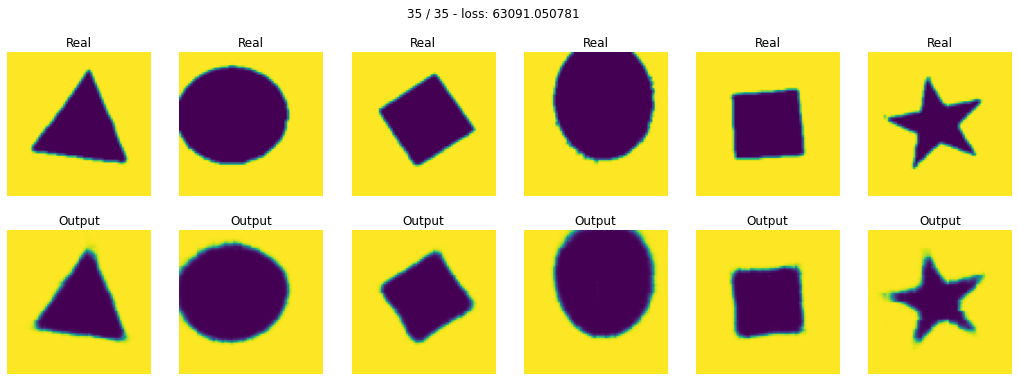

In [ ]:
#@title Учим!

epochs = 35 #@param {type:"integer"}

train(autoencoder, optimizer, criterion, epochs, data_tr, data_val)

# Изучаем распределение

In [ ]:
t_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)
val = next(iter(t_loader))

with torch.no_grad():
  z,_ = autoencoder.encode(val[0].to(device))
  z = z.cpu()

In [ ]:
_z_ = z

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random',perplexity=3).fit_transform(z)
tsne.shape

(2994, 2)

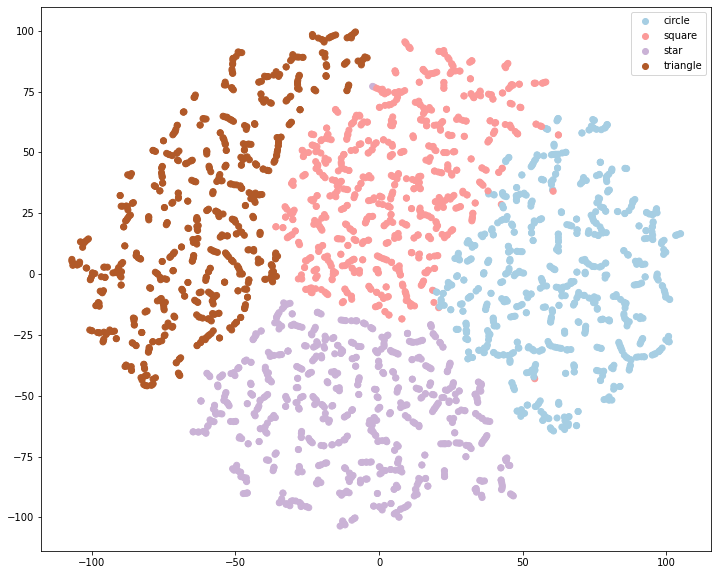

In [ ]:
#@title Распределение
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(10)
cax=ax.scatter(tsne[:,0],tsne[:,1],c=val[1], cmap='Paired')
plt.legend(handles=cax.legend_elements()[0], labels=labels)

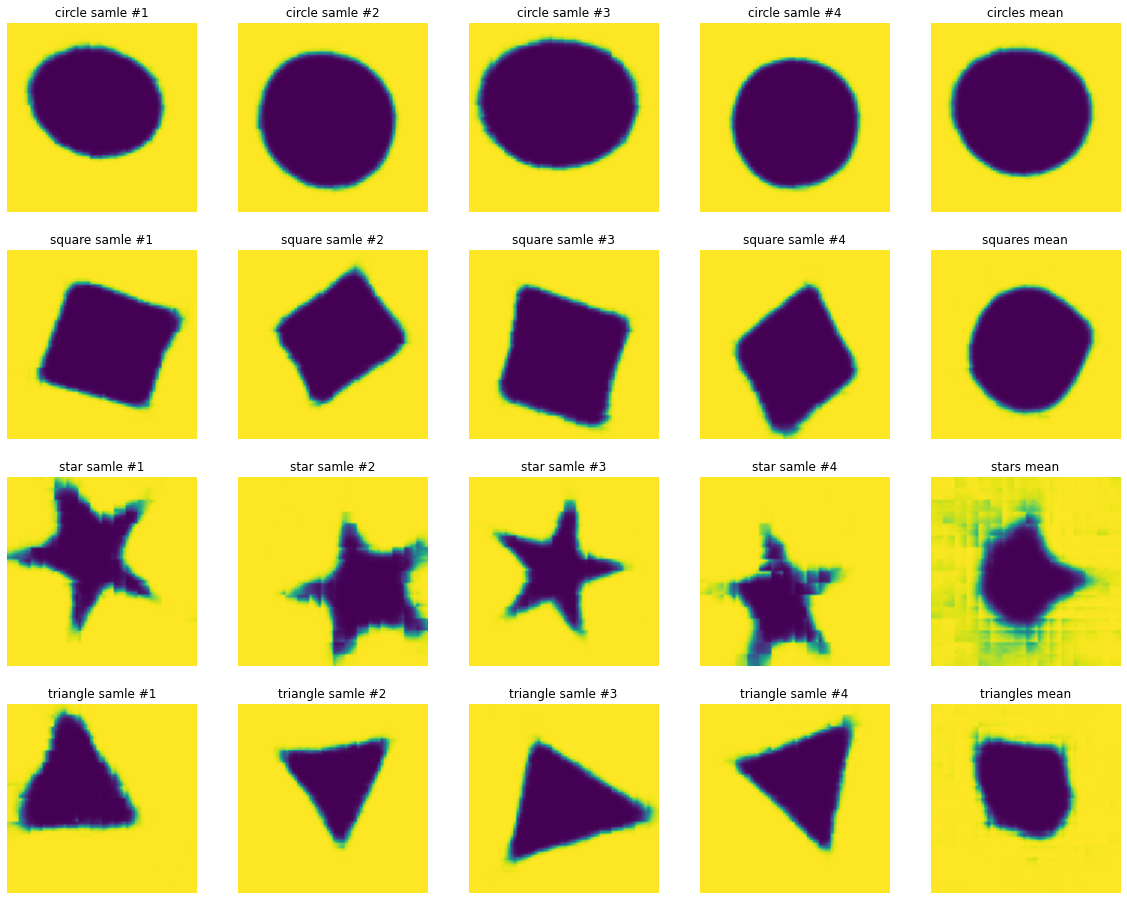

In [ ]:
#@title А если усреднить? (так себе идея)
plt.figure(figsize=(20, 16))
with torch.no_grad():
  for i in range(4):
    z,_ = autoencoder.encode(val[0][val[1]==i][:4].to(device))
    img = autoencoder.decode(z).cpu()#z = z.cpu()
    #print(img.shape)
    for j in range(4):
      plt.subplot(4, 5, i*5+j+1)
      plt.title(labels[i]+' samle #'+str(j+1))
      plt.axis("off")
      plt.imshow(img[j].squeeze())
    img = autoencoder.decode(z.mean(dim=0)).cpu()
    plt.subplot(4, 5, i*5+5)
    plt.title(labels[i]+'s mean')
    plt.axis("off")
    plt.imshow(img.squeeze())

  plt.show();

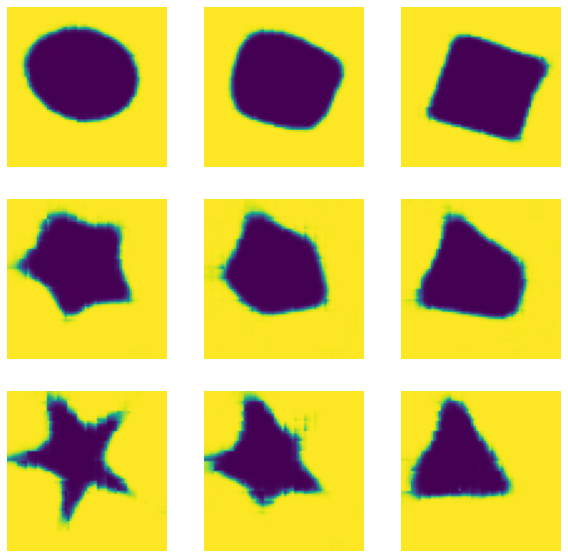

In [ ]:
#@title Морфим разные фигуры друг в друга
#t = val[1]
#print ((t == 2).nonzero(as_tuple=True)[0])

with torch.no_grad():
  shapes = []
  transitions = []

  for i in range(4):
    z,_ = autoencoder.encode(val[0][val[1]==i][:1].to(device))
    z = z.cpu()
    shapes.append(z.mean(dim=0).unsqueeze(0))

  transitions.append(shapes[0])
  transitions.append(torch.cat((shapes[0],shapes[1])).mean(dim=0))
  transitions.append(shapes[1])

  transitions.append(torch.cat((shapes[0],shapes[2])).mean(dim=0))
  transitions.append(torch.cat(shapes).mean(dim=0))
  transitions.append(torch.cat((shapes[1],shapes[3])).mean(dim=0))

  transitions.append(shapes[2])
  transitions.append(torch.cat((shapes[2],shapes[3])).mean(dim=0))
  transitions.append(shapes[3])

  plt.figure(figsize=(10, 10))
  for i in range(9):
    plt.subplot(3, 3, i+1)
    #plt.title(labels[train_data[j][1]])
    plt.axis("off")
    img = autoencoder.decode(transitions[i].to(device)).cpu()
    plt.imshow(img.squeeze())
  plt.show();


torch.Size([6, 1, 64, 64])


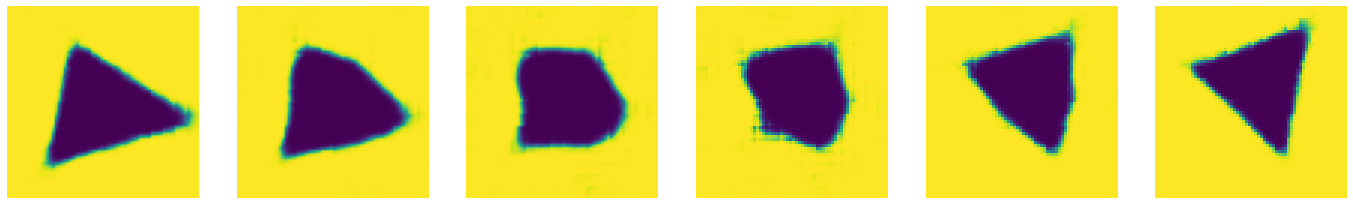

In [ ]:
#@title И просто один треугольник в другой
plt.figure(figsize=(24, 4))
with torch.no_grad():
  z,_ = autoencoder.encode(val[0][val[1]==3][2:4].to(device))
  shapes = []
  for i in range(6):
    shapes.append(torch.lerp(z[:1],z[-1:],0.2*i))
  z = torch.cat(shapes)
  img = autoencoder.decode(z).cpu()
  print(img.shape)
  for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(img[i,0,:,:])

  plt.show();

# k-nearest

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

t_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=2048, shuffle=False)
#val = next(iter(t_loader))
zz=[]
cls=[]
with torch.no_grad():
  for batch in data_tr:
    z,_ = autoencoder.encode(batch[0].to(device))
    zz.append(z.cpu())
    cls.append(batch[1])

zz = torch.cat(zz)
cls = torch.cat(cls)

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(zz, cls)


KNeighborsClassifier()

In [ ]:
Wrong = neigh.predict(_z_) != val[1].numpy()

print(f"Промазали в {sum(Wrong)} случаях из {len(val[1])} тестовых!")


Промазали в 3 случаях из 2994 тестовых!


In [ ]:
lb = neigh.predict(_z_)[Wrong]
shp = val[0][Wrong]

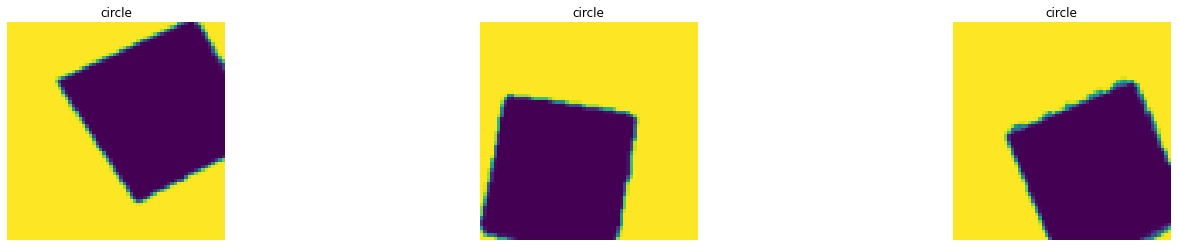

In [ ]:
plt.figure(figsize=(24, 4))
with torch.no_grad():
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    plt.imshow(shp[i,0,:,:])
    plt.title(labels[lb[i]])
  plt.show();